In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../data/user_detail.csv')

In [3]:
df.review = df.review.apply(lambda x: x.replace('\r', ' ')) 
df.review = df.review.apply(lambda x: x.replace('\n', ' '))
df.review = df.review.apply(lambda x: x.replace("\\" , ""))

In [4]:
df.review.loc[1]

'I have played Lithium: Inmate 39 and it seems a very interesting game, it really has a good atmosphere something between a Tim Burton film with a more gory result. The game makes you remember old horror games like Nightmare Creatures, Silent Hill, Resident Evil and their challenge.'

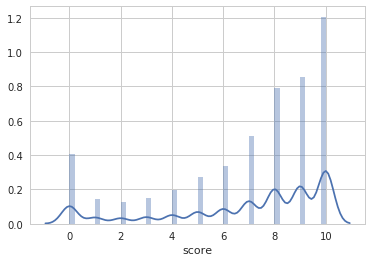

In [5]:
%matplotlib inline
sns.distplot(df.score)
plt.show()

In [6]:
df.score = df.score.apply(lambda x: 0 if x< 6 else 1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.review, df.score)

len(X_train), len(X_test), len(y_train), len(y_test)

(75830, 25277, 75830, 25277)

In [8]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,2), stop_words='english'
                            ,tokenizer =nltk.word_tokenize)), 
    ('clf', MultinomialNB(alpha=0.01))])

model = clf.fit(X_train, y_train)

model

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
  ...ue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))])

In [9]:
from sklearn.metrics import *

y_pred = model.predict(X_test)

print("acc:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

acc: 0.8642243937176088
[[ 3610  2892]
 [  540 18235]]
             precision    recall  f1-score   support

          0       0.87      0.56      0.68      6502
          1       0.86      0.97      0.91     18775

avg / total       0.86      0.86      0.85     25277



### test

In [10]:
X_test = X_test.reset_index(drop=True)
X_test[0][:100], X_test[1][:100], X_test[2][:100]

result = model.predict([X_test[0], X_test[1], X_test[2]])
result

array([1, 1, 1])

In [11]:
classification_dict = {
    0: "bad", 1: "good",
}

for idx, category in enumerate(result):
    print(classification_dict[category], X_test[idx][:50])

good A decent game , the story was quiet boring althoug
good The Devil May Cry collection is just as great on t
good Its a solid 7 like the critics say..... If it was 


---

In [12]:
test = df[['review', 'score']]

In [13]:
test.to_csv('test.csv', index=False)

In [14]:
test.tail()

,review,score
101102,Had fun with it after playing through on easy ...,1
101103,I get the distinct impression that Rare stumbl...,1
101104,"What you have here is a very well rounded, inc...",1
101105,"A real step up from the previous game, but spo...",0
101106,Konami Cancelled Zone of the Enders 3. A small...,1


In [15]:
def stream_docs(path):
    with open(path, 'r') as csv:
        next(csv) #skip header
        for line in csv:
            text, label = line[1:-4], int(line[-2])
            yield text, label

In [16]:
next(stream_docs(path='./test.csv'))

("Kazuma Kiryu's last game (no spoilers)  I managed to get Yakuza 6 a little earlier and my opinion on it is highly positive. The game is really immersive with a cast made out of very wholesome, comedic and plain evil characters. The story takes you to both Onomichi and Kamurocho in yet another tale of our beloved Dragon.  The story itself is really good. Yakuza 6 has a really interesting plot and definitely goes for that less grim Yakuza 5 atmosphere in comparison to the one that we had in 0. The substories this time around are fully voiced. The substories can be sad, funny and have a whole lot of effort put in them. The substory-voice actors really did put that extra weight on their characters and it really helps out because not every character has that much screen time.  The mini games including the new Clan Creator, Baseball manager and underwater fishing game are done really well. One moment you're fighting a squid monster that fires little squids as projectiles and other moments 

In [17]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
         for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [18]:
from sklearn.feature_extraction.text import HashingVectorizer

vect = HashingVectorizer(
#                         ngram_range=(1,2), 
                        stop_words='english',
                        decode_error='ignore',
                        n_features=2**21,
                        preprocessor=None,
#                         non_negative=True,
                        tokenizer =nltk.word_tokenize,
                        )

In [19]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='log', random_state=1, max_iter=1)

In [20]:
import pyprind
import pickle

pbar = pyprind.ProgBar(31)
classes = np.array([0, 1])
for _ in range(31):
    X_train, y_train = get_minibatch(stream_docs(path='./test.csv'), size = 5000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:06:22


In [21]:
X_test, y_test = get_minibatch(stream_docs(path='./test.csv'), size=10000)

In [22]:
X_test = vect.transform(X_test)

In [23]:
y_pred = clf.predict(X_test)

print("acc:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

acc: 0.865
[[ 884 1221]
 [ 129 7766]]
             precision    recall  f1-score   support

          0       0.87      0.42      0.57      2105
          1       0.86      0.98      0.92      7895

avg / total       0.87      0.86      0.85     10000



In [24]:
clf.partial_fit(X_test, y_test)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=1, shuffle=True,
       tol=None, verbose=0, warm_start=False)

update